In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os

In [0]:
covid_path = os.path.join(os.path.abspath('.'), 'drive', 'My Drive', 'IT', 'Python', 'covid', 'plots')

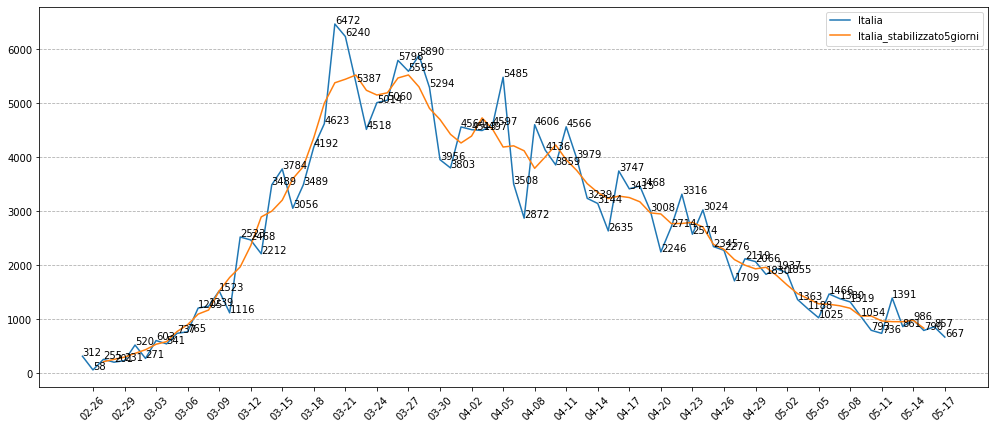

In [34]:
#@ title Cresciata giornaliera di contagi sull\'intero territorio Italiano

import requests
import pandas as pd
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

rilevazioni = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')
rilevazioni['data'] = rilevazioni['data'].apply(lambda x : x[5:10])
rilevazioni = rilevazioni.drop(rilevazioni[rilevazioni['denominazione_provincia'] == 'In fase di definizione/aggiornamento'].index)
rilevazioni = rilevazioni.pivot_table(index=['denominazione_regione','denominazione_provincia'], columns='data', values='totale_casi')
rilevazioni.index.names = ['Regione', 'Provincia']


def avg_serie(dataset, day=5, add_name=True):
  avg_df = pd.DataFrame(index=dataset.index.copy())

  for pos in range(day-1, len(dataset.columns)):
    avg_df[dataset.columns[pos - round(day/2)]] = dataset.iloc[:,pos-day+1:pos+1].mean(axis=1)
  avg_df = avg_df.astype('int32')
  if add_name:
    if not hasattr(avg_df.index, 'levels'):
      avg_df.set_index(avg_df.index+'_stabilizzato'+str(day)+'giorni', inplace=True)
    else:
      avg_df.index.set_levels(avg_df.index.levels[1]+'_stabilizzato'+str(day)+'giorni',level=1, inplace=True)
  return avg_df

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(17, 7), avg=False, annotation=True, path=None):
  if avg!=False:
    tmp = pd.concat([df,avg_serie(df,avg)])
  else:
    tmp = df
  ax = tmp.T.plot(figsize=figsize, title=title)
  step_size = max(round(len(df.columns) / 25 - 0.5),1)
  resto = (len(df.columns)-1) % step_size
  ax.set_xticks(ticks=np.arange(resto, len(df.columns) , step=step_size))
  tick_label = list(df.columns)[resto::step_size]
  ax.set_xticklabels(tick_label, rotation=45)
  ax.grid(axis='y', linestyle='--')

  #ax.yaxis.tick_right()
  if annotation == True:
    count = 0
    for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
      #if count % 2 == 0:
      for el in v[1]:
        ax.annotate(el, (k + xdelta, el + ydelta))
      count +=1
  if path != None:
    plt.savefig(path)
  return ax


sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]
crescita = pd.DataFrame(index=sorted_by_infections.index)
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']


_ = plot_annotate(crescita_italia, avg=5,path=covid_path+'/Italia.jpg')

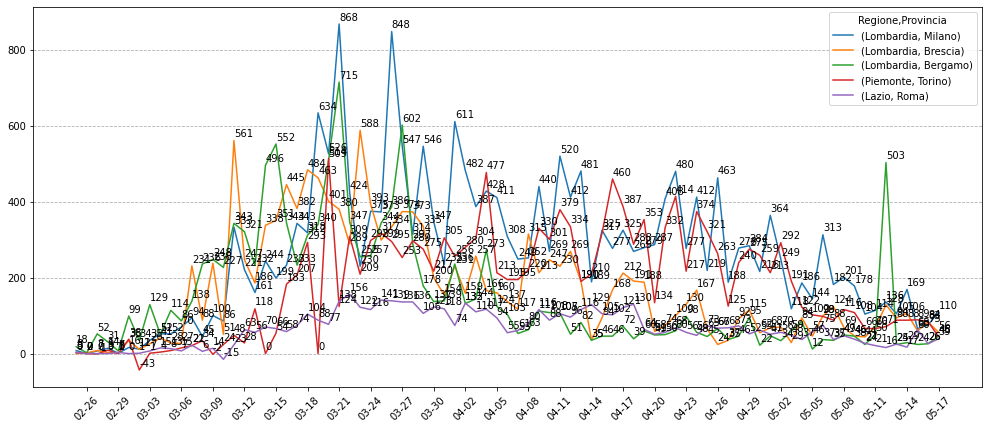

In [35]:
#@ title Crescita giornaliere di contagi per le province con maggior crescita
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(5),path=covid_path+'/Provincie-01.jpg')
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

In [36]:
xx = crescita.sort_values(by=crescita.columns[-1], ascending=False).iloc[:13,-3:].T
with open(covid_path+'/frame01.html', 'w') as out:
  out.write(xx.to_html())
xx

Regione   Lombardia                  ... P.A. Trento Emilia-Romagna   Marche
Provincia    Milano Brescia Bergamo  ...      Trento        Bologna Macerata
05-15            66      60      24  ...           3             12        5
05-16            75      83      26  ...           8             15        5
05-17           110      56      46  ...          12             12       11

[3 rows x 13 columns]

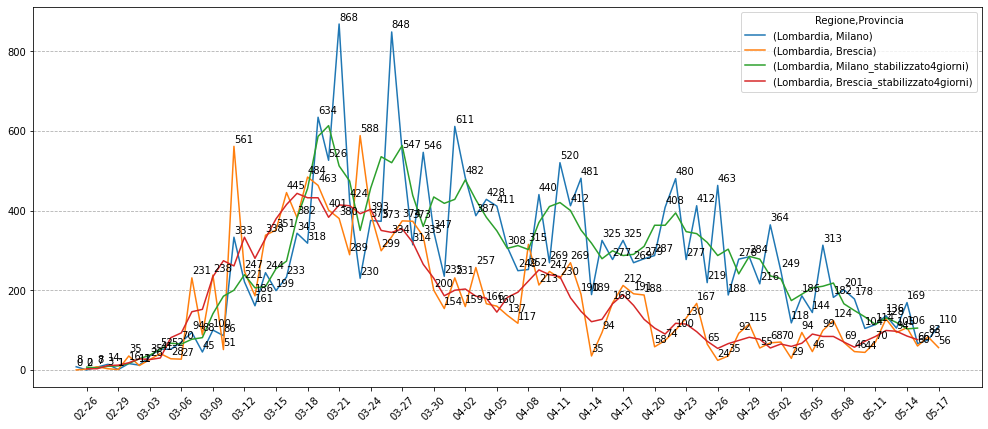

In [37]:
#@ title Crescita giornaliera di contagi mediata su un intervallo di 4 giorni per le province con maggior crescita
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(2), avg=4, path=covid_path+'/Provincie-02.jpg')
#_ = plot_annotate(avg_serie(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(5), day=4))

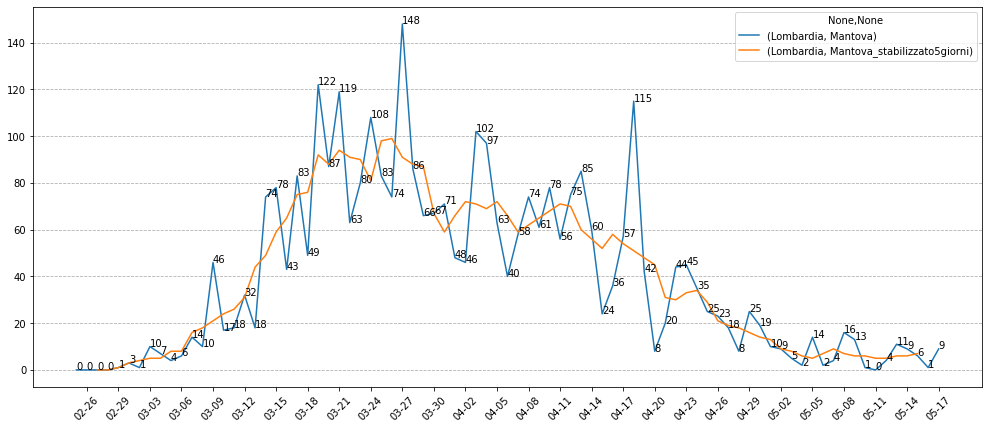

In [38]:
#@ title Crescita giornaliera di contagi a Mantova
_ = plot_annotate(crescita.loc[('Lombardia','Mantova')].to_frame().T, ydelta=0, avg=5, path=covid_path+'/Mantova.jpg')

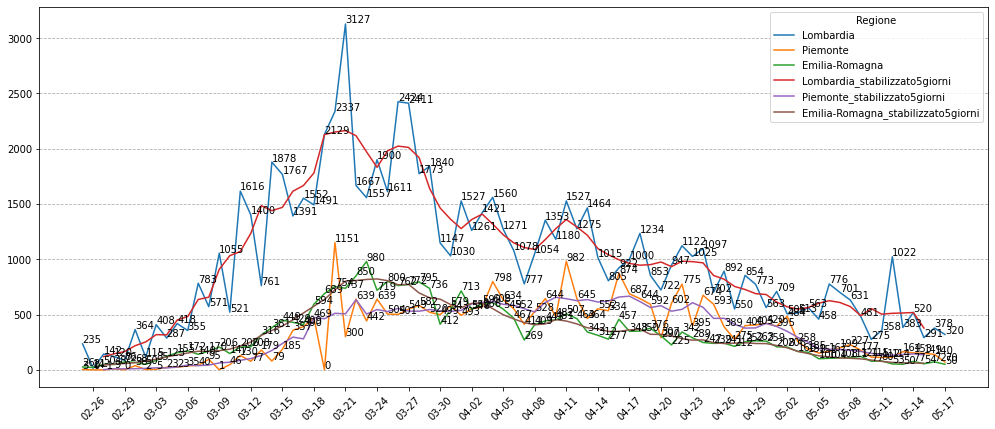

In [39]:
#@ title Crescita giornaliera per le regioni maggiormente infette
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(3), avg=5, path=covid_path+'/Regioni.jpg')


In [40]:
xx = crescita_regioni.iloc[:10,-3:].T
with open(covid_path+'/frame02.html', 'w') as out:
  out.write(xx.to_html())
xx

Regione,Lombardia,Piemonte,Emilia-Romagna,Veneto,Toscana,Liguria,Lazio,Marche,Campania,Puglia
05-15,291,149,54,42,24,65,73,15,15,9
05-16,378,140,72,29,30,51,32,23,24,8
05-17,320,70,50,15,35,48,49,24,8,5


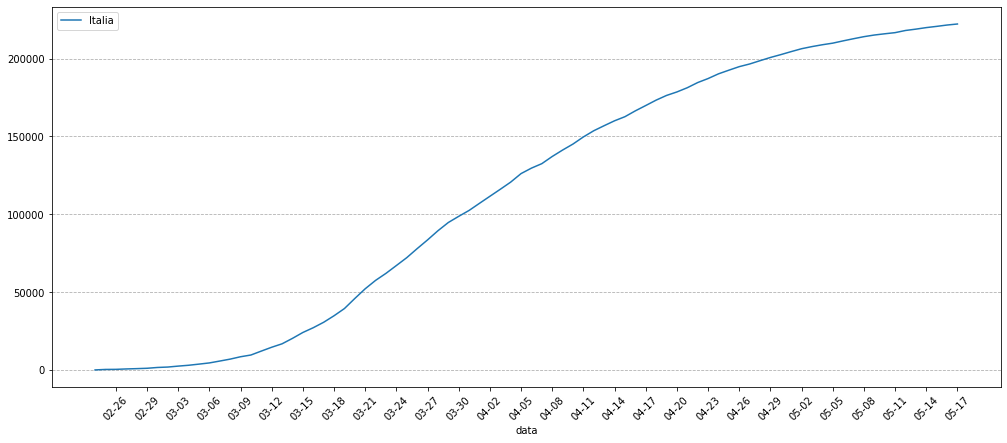

In [41]:
#@ title Contagi totali in Italia
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']
_ = plot_annotate(casi_italia, xdelta=0.5, annotation=False, path=covid_path+'/Totale Italia.jpg')

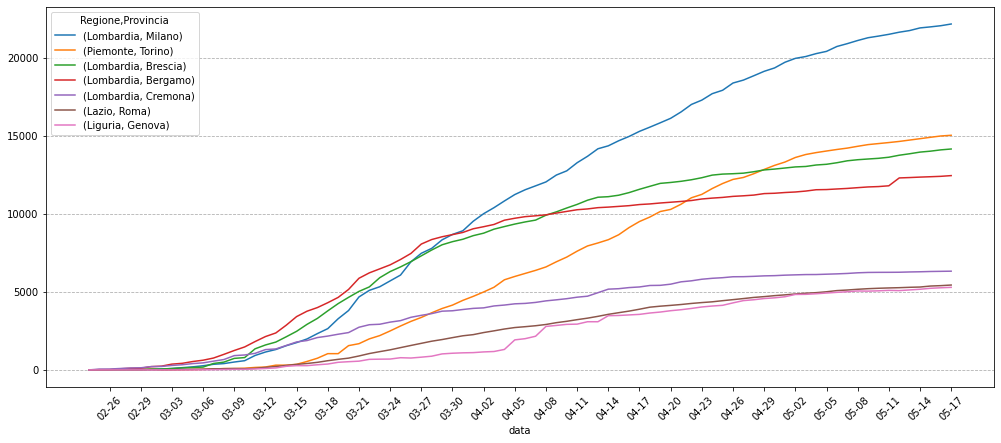

In [42]:
#@ title Contagi totali per le province maggiormente infette
_ = plot_annotate(sorted_by_infections.head(7), annotation=False, path=covid_path+'/Totale Provincie.jpg')

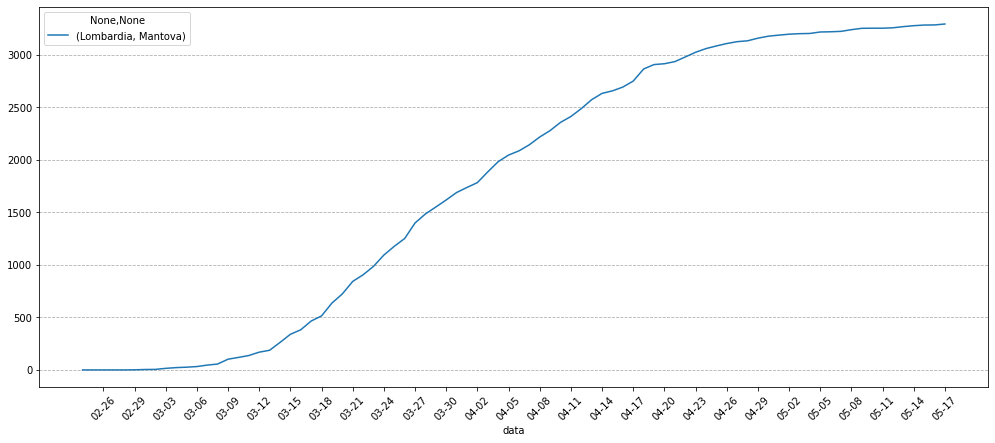

In [43]:
#@ title Contagi totali a Mantova
_ = plot_annotate(sorted_by_infections.loc[('Lombardia','Mantova')].to_frame().T, annotation=False, path=covid_path+'/Totale Mantova.jpg')

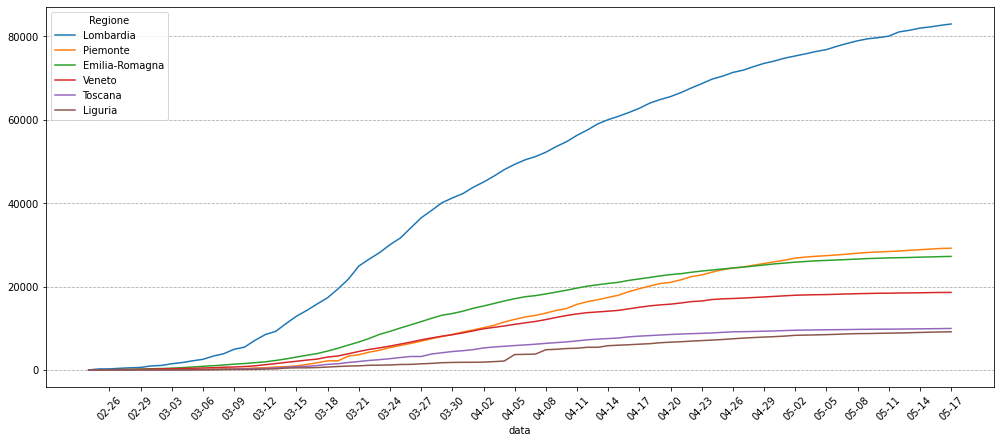

In [45]:
#@ title Contagi totali regioni
_ = plot_annotate(regioni.head(6), annotation=False, path=covid_path+'/Totale regioni.jpg')